<a href="https://colab.research.google.com/github/avkaz/DeepLearningPetIdentification/blob/baseline/baseline_exper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

imports

In [142]:
## 1st -  Download utility.py file from github repository
## 2nd - Imports all functions from utility.py

import requests

# Correct raw URL for the utility.py file
url = "https://raw.githubusercontent.com/avkaz/DeepLearningPetIdentification/main/utility.py"

# Fetch and save the file locally
response = requests.get(url)
with open("utility.py", "wb") as f:
    f.write(response.content)


import utility
print("utility.py downloaded successfully.")

import tensorflow as tf

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
import requests
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from io import BytesIO
import pandas as pd
from google.colab import files
!pip install faiss-gpu
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
import faiss

utility.py downloaded successfully.


data

In [143]:
data = utility.get_data()
trypets = list(data.items())[:20]
#trypets

model

In [146]:
model = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg')

deleting instances with multiple pets in one posting


In [147]:
f_trypets = [
    pet for pet in trypets
    if not any(part.startswith('a') for part in pet[0].split('-')[1:])
]
#f_trypets

[('tanyny-chomutov-2024-12-21',
  {'Jméno': 'Tanyny',
   'Pohlaví': 'Samec',
   'Kraj': 'Ústecký',
   'Okres': 'Chomutov',
   'Plemeno': 'Kříženec',
   'Věk': '5 let',
   'Barva': 'Černá',
   'Velikost': 'Střední - 10-17kg',
   'url': 'https://www.psidetektiv.cz/zvire/tanyny-chomutov-2024-12-21',
   'images': ['https://www.psidetektiv.cz/data/catalog/big/2024/12/22/img190390.jpg',
    'https://www.psidetektiv.cz/data/catalog/big/2024/12/22/img190391.jpg',
    'https://www.psidetektiv.cz/data/catalog/big/2024/12/22/img190392.jpg',
    'https://www.psidetektiv.cz/data/catalog/big/2024/12/22/img190393.jpg',
    'https://www.psidetektiv.cz/data/catalog/big/2024/12/22/img190394.jpg']}),
 ('haily-tachov-2024-12-21',
  {'Jméno': 'Haily',
   'Pohlaví': 'Samice',
   'Kraj': 'Plzeňský',
   'Okres': 'Tachov',
   'Plemeno': 'Jezevčík',
   'Věk': '5 let',
   'Barva': 'Tmavý divočák',
   'Velikost': 'Střední - 10-17kg',
   'url': 'https://www.psidetektiv.cz/zvire/haily-tachov-2024-12-21',
   'images

create embeddings

In [148]:
# embeddings for FAISS
all_embeddings = []
all_pet_names = []
all_image_urls = []

for pet_id, pet_info in f_trypets:
    pet_name = pet_info['Jméno']
    for image_url in pet_info["images"]:
        embedding = utility.download_and_preprocess_image(image_url, target_size=(224, 224))
        if embedding is not None:
            all_embeddings.append(embedding.numpy().flatten())  # flatten
            all_pet_names.append(pet_name)
            all_image_urls.append(image_url)

all_embeddings = np.array(all_embeddings)

faiss

In [155]:
# normalize embeddings
def normalize_embeddings(embeddings):
    norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
    return embeddings / norms

normalized_embeddings = normalize_embeddings(all_embeddings)

# create FAISS indexes
l2_index = faiss.IndexFlatL2(all_embeddings.shape[1])
cosine_similarity_index = faiss.IndexFlatIP(all_embeddings.shape[1])

# add embeddings to indexes
l2_index.add(all_embeddings)
cosine_similarity_index.add(normalized_embeddings)

# unique pet indices
unique_pet_indices = {name: idx for idx, name in enumerate(all_pet_names)}.values()

# test function
def test_pet_retrieval(test_embedding_index, k=5):
    test_embedding = all_embeddings[test_embedding_index:test_embedding_index + 1]
    test_embedding_normalized = normalized_embeddings[test_embedding_index:test_embedding_index + 1]

    l2_distances, l2_indices = l2_index.search(test_embedding, k)
    cosine_sim_scores, cosine_sim_indices = cosine_similarity_index.search(test_embedding_normalized, k)

    results = []
    for rank, (l2_dist, l2_idx, cos_sim_score, cos_sim_idx) in enumerate(
        zip(l2_distances[0], l2_indices[0], cosine_sim_scores[0], cosine_sim_indices[0]), start=1
    ):
        results.append({
            "Rank": rank,
            "Test_Pet": all_pet_names[test_embedding_index],
            "Matched_Pet_L2": all_pet_names[l2_idx],
            "Matched_Pet_Cosine": all_pet_names[cos_sim_idx],
            "L2_Distance": l2_dist,
            "Cosine_Similarity": cos_sim_score,
            "Image_URL_L2": all_image_urls[l2_idx],
            "Image_URL_Cosine": all_image_urls[cos_sim_idx],
        })

    return results

# test on unique pets
for idx in unique_pet_indices:
    print(f"\ntested pet: {all_pet_names[idx]}")
    results = test_pet_retrieval(idx)
    for res in results:
        print(res)



tested pet: Tanyny
{'Rank': 1, 'Test_Pet': 'Tanyny', 'Matched_Pet_L2': 'Tanyny', 'Matched_Pet_Cosine': 'Tanyny', 'L2_Distance': 0.0, 'Cosine_Similarity': 0.9998541, 'Image_URL_L2': 'https://www.psidetektiv.cz/data/catalog/big/2024/12/22/img190394.jpg', 'Image_URL_Cosine': 'https://www.psidetektiv.cz/data/catalog/big/2024/12/22/img190394.jpg'}
{'Rank': 2, 'Test_Pet': 'Tanyny', 'Matched_Pet_L2': 'Želva', 'Matched_Pet_Cosine': 'Tanyny', 'L2_Distance': 7621.1436, 'Cosine_Similarity': 0.8709577, 'Image_URL_L2': 'https://www.psidetektiv.cz/data/catalog/big/2024/12/19/img190186.jpg', 'Image_URL_Cosine': 'https://www.psidetektiv.cz/data/catalog/big/2024/12/22/img190393.jpg'}
{'Rank': 3, 'Test_Pet': 'Tanyny', 'Matched_Pet_L2': 'Tanyny', 'Matched_Pet_Cosine': 'Tanyny', 'L2_Distance': 7742.9434, 'Cosine_Similarity': 0.8643462, 'Image_URL_L2': 'https://www.psidetektiv.cz/data/catalog/big/2024/12/22/img190391.jpg', 'Image_URL_Cosine': 'https://www.psidetektiv.cz/data/catalog/big/2024/12/22/img1903

the match is considered true if the test pet matches the matched pet in at least two instances, goal is to compare similarity metrics.

true matches:
   Test_Pet  L2_True_Match  Cosine_True_Match
0    Tanyny           True               True
1     Haily           True              False
2       Egy           True              False
3     Randy           True              False
4     Alfík          False               True
5     Juicy          False              False
6      Urri           True               True
7      Lily           True              False
8    Užovka          False              False
9      Endy           True               True
10     Gigy          False              False
11      Rey          False              False
12    Želva          False              False
13   Terina           True               True
14    Pedro           True              False
15      Ira           True              False
16    Adolf          False              False


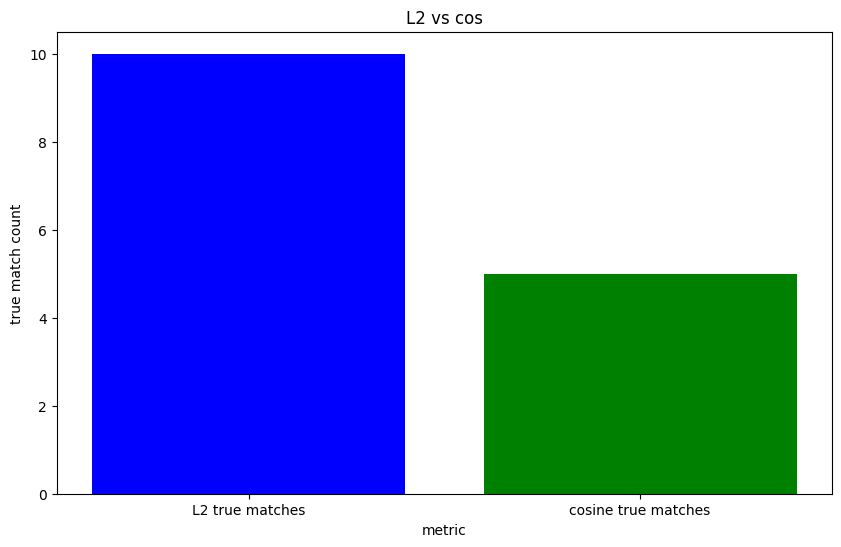

In [154]:
# check if match is true for a metric
def is_true_match_for_metric(matches, test_pet_name):
    return sum(1 for match in matches if match == test_pet_name) >= 2

# compare results for L2 and Cosine similarity
def compare_metrics(test_pet_idx, k=5):
    results = test_pet_retrieval(test_pet_idx, k)
    l2_matches = [result['Matched_Pet_L2'] for result in results]
    cos_matches = [result['Matched_Pet_Cosine'] for result in results]
    test_pet_name = all_pet_names[test_pet_idx]

    return {
        'Test_Pet': test_pet_name,
        'L2_Matches': l2_matches,
        'Cosine_Matches': cos_matches,
        'L2_True_Match': is_true_match_for_metric(l2_matches, test_pet_name),
        'Cosine_True_Match': is_true_match_for_metric(cos_matches, test_pet_name)
    }

# compare metrics for each pet
comparison_results = [compare_metrics(idx) for idx in unique_pet_indices]

# create DataFrame for results
def create_results_dataframe(comparison_results):
    return pd.DataFrame([{
        'Test_Pet': res['Test_Pet'],
        'L2_True_Match': res['L2_True_Match'],
        'Cosine_True_Match': res['Cosine_True_Match']
    } for res in comparison_results])

comparison_df = create_results_dataframe(comparison_results)

# display true matches
print("true matches:")
print(comparison_df)

# plot histogram for L2 vs Cosine true matches
plt.figure(figsize=(10, 6))
plt.bar(['L2 true matches', 'cosine true matches'], [
    comparison_df['L2_True_Match'].sum(),
    comparison_df['Cosine_True_Match'].sum()
], color=['blue', 'green'])

plt.xlabel('metric')
plt.ylabel('true match count')
plt.title('L2 vs cos')
plt.show()
